Fusobacterium nucleatum - Fusobacteria
Porphyromonas - Porphyromonadaceae
Gemella - Firmicutes 

In [169]:
Learning_features = ["Firmicutes", "Fusobacteria", "Bacteroidia", "Porphyromonadaceae", "Gemella",
                     "Porphyromonas", "Prevotella", "Fusobacterium nucleatum"]

In [43]:
Learning_features = ["Firmicutes", "Fusobacteria", "Bacteroidia", "Porphyromonadaceae",
                     "Prevotella"]

In [53]:
Learning_features_kraken = ["Firmicutes", "Fusobacteria", "Bacteroidia", "Porphyromonadaceae", "Porphyromonas",
                            "Porphyromonas asaccharolytica", "Prevotella intermedia", "Fusobacterium nucleatum", 
                            "Parvimonas micra"]

In [38]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [3]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [4]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv']


In [5]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [162]:
def get_df(df_name, table_files, features):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    #df = get_data_for_sample(table_files[index])
    df = df.loc[[name in features for name in df["Name"]]]
    #df = df.loc[df["Rank"]=="S"]
    
    return df
    
    

In [163]:
df = get_df("FengQ_2015", files_kraken, Learning_features_kraken)

In [127]:
df.head()

,Unnamed: 0,Sample_ID,Dataset,Rank,Name,Abundance,STUDY_CONDITION,BODY_SITE,SUBJECTID,COUNTRY,DISEASE,AGE,AGE_CATEGORY
0,0,ERR688526,FengQ_2015.csv,U,unclassified,70.88,adenoma,stool,SID31282,AUT,adenoma;fatty_liver,63,adult
1,1,ERR688526,FengQ_2015.csv,R,root,29.12,adenoma,stool,SID31282,AUT,adenoma;fatty_liver,63,adult
2,2,ERR688526,FengQ_2015.csv,R1,cellular organisms,29.11,adenoma,stool,SID31282,AUT,adenoma;fatty_liver,63,adult
3,3,ERR688526,FengQ_2015.csv,D,Bacteria,29.05,adenoma,stool,SID31282,AUT,adenoma;fatty_liver,63,adult
4,4,ERR688526,FengQ_2015.csv,D1,Terrabacteria group,25.38,adenoma,stool,SID31282,AUT,adenoma;fatty_liver,63,adult


In [164]:
data_1 = df[["Sample_ID", "Name", "Abundance"]]

In [165]:
target_1 = df[["Sample_ID", "STUDY_CONDITION"]].drop_duplicates()

In [166]:
data = data_1.pivot(index='Sample_ID', columns='Name', values='Abundance')
data = data.fillna(0)

In [152]:
data.head()

Name,Bacteroidia,Firmicutes,Fusobacteria,Fusobacterium nucleatum,Parvimonas micra,Porphyromonadaceae,Porphyromonas,Porphyromonas asaccharolytica,Prevotella intermedia
Sample_ID,,,,,,,,,
ERR688505,6.77,25.10,0.01,0.0,0.00,0.01,0.0,0.0,0.01
ERR688506,2.84,15.95,0.02,0.0,0.00,0.01,0.0,0.0,0.00
ERR688507,1.89,23.13,0.01,0.0,0.00,0.00,0.0,0.0,0.00
ERR688508,3.20,14.70,0.03,0.0,0.01,0.01,0.0,0.0,0.01
ERR688509,0.82,20.35,0.02,0.0,0.00,0.00,0.0,0.0,0.00


In [153]:
data = data[["Fusobacteria", "Parvimonas micra", "Porphyromonadaceae", "Porphyromonas",
             "Porphyromonas asaccharolytica", "Prevotella intermedia"]]

In [87]:
data_m = data[["Fusobacteria", "Porphyromonadaceae"]]

In [167]:
target = target_1.set_index("Sample_ID")
target["TARGET"] = [1 if s in ["CRC"] else 0 for s in target["STUDY_CONDITION"]]

/gfs/progs/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


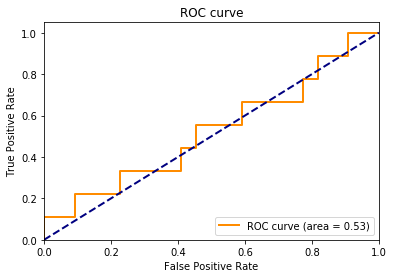

In [168]:
# Logisztikus regresszió
x_train, x_test, y_train, y_test = train_test_split(data, target.TARGET, test_size=0.2, random_state=0)
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

#Konfidencia scoreok a teszt halmazhoz
y_score = logisticRegr.decision_function(x_test)

#ROC görbe számolása
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( 'ROC curve')
plt.legend(loc="lower right")

plt.savefig("ancom_log_reg_roc_fengq.png", dpi=200)

coef = logisticRegr.coef_[0]
columns = data.columns

weights = []
for i in range(len(coef)):
    weights.append((coef[i], columns[i]))
weights = sorted(weights, key = lambda weight: weight[0])

In [84]:
coef = logisticRegr.coef_[0]

In [85]:
coef

array([ 0.68760261,  0.10568887,  0.31459904,  0.3000402 ,  0.29359556,
       -0.34632811])

In [96]:
X[:, 1]

array([0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.02, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.02, 0.05, 0.  , 0.  ,
       0.01, 0.65, 1.65, 0.01, 0.3 , 0.02, 0.55, 0.13, 0.02, 0.01, 1.34,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.01,
       0.  , 0.01, 0.02, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.02,
       0.  , 0.01, 0.03, 0.01, 0.01, 0.01, 0.02, 0.02, 0.  , 0.04, 0.02,
       0.02, 0.  , 0.  , 0.01, 0.05, 0.03, 0.  , 0.  , 0.05, 0.01, 0.27,
       0.02, 0.  , 0.01, 0.03, 0.  , 0.01, 0.01, 0.

https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html

In [101]:
print(__doc__)

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# import some data to play with

x_train, x_test, y_train, y_test = train_test_split(data_m, target.STUDY_CONDITION, test_size=0.2, random_state=0)

#X = data_m.values  # we only take the first two features.
#Y = target.STUDY_CONDITION

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(x_train, y_train)


Automatically created module for IPython interactive environment


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [103]:
#Konfidencia scoreok a teszt halmazhoz
y_score = logreg.decision_function(x_test)

#ROC görbe számolása
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( 'CRC ROC görbe')
plt.legend(loc="lower right")
plt.show()

coef = logisticRegr.coef_[0]
columns = data.columns

weights = []
for i in range(len(coef)):
    weights.append((coef[i], columns[i]))
weights = sorted(weights, key = lambda weight: weight[0])

array([[-0.22330079, -0.17443075,  0.39773155],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.15578345, -0.12331046,  0.27909391],
       [-0.1761013 , -0.13981348,  0.31591478],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.1761013 , -0.13981348,  0.31591478],
       [-0.12202477, -0.09775032,  0.21977509],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.1560967 , -0.12914511,  0.28524181],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.18954212, -0.14887061,  0.33841273],
       [-0.15578345, -0.12331046,  0.27909391],
       [-0.14234263, -0.11425333,  0.25659596],
       [-0.15578345, -0.12331046,  0.27909391],
       [-0.16266048, -0.13075635,  0.29341683],
       [-0.1761013 , -0.13981348,  0.31591478],
       [-0.1761013 , -0.13981348,  0.315

In [ ]:

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

y = label_binarize(target.STUDY_CONDITION, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(data_m.values, y, test_size=0.2, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Can only tuple-index with a MultiIndex